# 1

In [142]:
from scipy.interpolate import barycentric_interpolate
import numpy as np


N = 11
INTERVAL = [-1, 1]


def original_function(x: np.ndarray):
    return np.exp(-np.power(x, 2))


def evenly_spaced_points(
    interval: tuple[int, int],
    num_nodes: int,
    x: np.ndarray,
):
    sp = np.linspace(*interval, num_nodes)
    return barycentric_interpolate(sp, original_function(sp), x)


def chebyshev_nodes(
    interval: tuple[int, int],
    num_nodes: int,
    x: np.ndarray,
):
    k = np.arange(0, num_nodes)
    ch = np.cos((2 * k + 1) * np.pi / (2 * num_nodes + 2))
    return barycentric_interpolate(ch, original_function(ch), x)
    
    

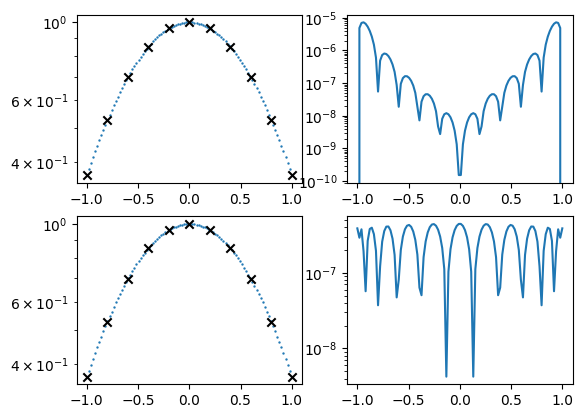

In [143]:
import matplotlib.pyplot as plt

fig, (axs1, axs2) = plt.subplots(2, 2)

x = np.linspace(*INTERVAL, 100)
pts = np.linspace(*INTERVAL, N)

for (ax, axerr), interpolation in zip([axs1, axs2], [evenly_spaced_points, chebyshev_nodes]):
    ax.scatter(x, interpolation(INTERVAL, N, x), marker='.', s=2)
    # ax.plot(x, original_function(x), color="red")
    ax.scatter(pts, original_function(pts), marker="x", color="black")
    ax.set_yscale('log')
    
    axerr.plot(x, np.abs(interpolation(INTERVAL, N, x) - original_function(x)))
    axerr.set_yscale('log')

## Comment

The Chebyshev nodes give a really good approximation: the maximum error is two orders of magnitude less when using Chebyshev nodes, than for evenly spaced nodes.

# 2

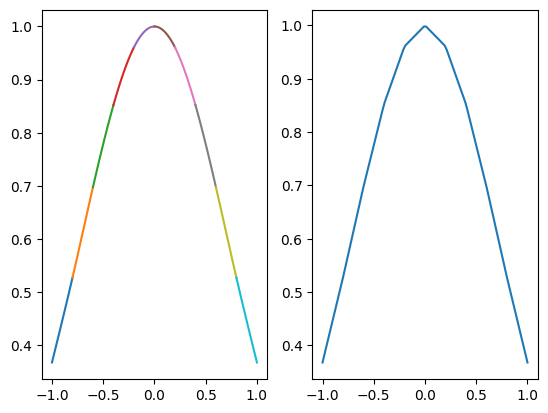

In [169]:
from scipy.linalg import solve_banded
from scipy.interpolate import interp1d

def get_cubic_splines(x_i: np.ndarray, y_i: np.ndarray):
    h_i = x_i[1:] - x_i[:-1]
    d_i = y_i[1:] - y_i[:-1]

    mu_i = 2 * (h_i[:-1] + h_i[1:])
    lam_i = (3 / h_i[1:]) * (y_i[2:] - y_i[1:-1]) - (3 / h_i[:-1]) * (
        y_i[1:-1] - y_i[:-2]
    )

    # mat = np.diag(h_i[:-2], -1) + np.diag([1] + mu_i, 0) + np.diag([0] + h_i[1:-1], 1)
    ab = np.vstack(
        [
            np.pad(h_i[1:-1], (2, 0)),
            np.pad(mu_i, (1, 0), "constant", constant_values=(1, 0)),
            np.pad(h_i[:-1], (0, 1)),
        ]
    )
    c_i = solve_banded((1, 1), ab, np.pad(lam_i, (1, 0)))
    c_i = np.pad(c_i, (0, 1))
    
    b_i = (1 / h_i) * (y_i[1:] - y_i[:-1]) - (h_i / 3) * (2 * c_i[:-1] + c_i[1:])
    d_i = (1 / (3 * h_i)) * (c_i[1:] - c_i[:-1])

    return y_i, b_i, c_i, d_i


a_i, b_i, c_i, d_i = get_cubic_splines(pts, original_function(pts))
S_i = lambda x, i: a_i[i] + b_i[i] * (x - pts[i]) + c_i[i] * np.power(x - pts[i], 2) + d_i[i] * np.power(x - pts[i], 3)

# print([S_i(np.linspace(a, b, 100 // len(pts)), i) for i, (a, b) in enumerate(intervals)])

intervals = [*zip(pts[:-1], pts[1:])]
y_cubic = np.hstack([S_i(np.linspace(a, b, 20), i) for i, (a, b) in enumerate(intervals)])

fig, (ax, axerr) = plt.subplots(1, 2)

for i, (a, b) in enumerate(intervals):
    x_n = np.linspace(a, b, 20)
    ax.plot(x_n, S_i(x_n, i))

axerr.plot(x, interp1d(pts, original_function(pts))(x))
# ax.plot(np.linspace(*INTERVAL, 20 * (N - 1)), y_cubic)

